======================== Import Packages ==========================

In [11]:
import os, sys, pdb
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join
import csv
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
from astroquery.vizier import Vizier
import warnings
from astropy.logger import AstropyWarning
warnings.filterwarnings('ignore', category=AstropyWarning)

========================== Define Functions ==========================

In [12]:
def get_data(catalog, join_key='Name', join_type='inner'):

    """
    PURPOSE:    Get data from literature with Vizier

    INPUT:      catalog = ctalog name on Vizier (str)
                join_key = column header to join tables, if multiple (str; optional)
                join_type = way to join tables, if multiple (str; optional)

    OUTPUT:     t = data table (AstroPy Table)

    """

    ### GET FULL CATALOG (ALL COLUMNS, ALL ROWS)
    viz = Vizier(catalog=catalog, columns=['**'])
    viz.ROW_LIMIT = -1
    tv = viz.get_catalogs(catalog)

    ### IF MULTIPLE TABLES, JOIN THEN
    for i, val in enumerate(tv.keys()):
        if i == 0:
            t = tv[val]
        else:
            tt = tv[val]
            if join_key in tt.columns:
                t = join(t, tt, join_type=join_type, keys=join_key)

    return t

In [13]:
def plot_grid(ax, gasgrid, low18=False):

    ### GET GAS MASSES FROM GRID
    mgas = gasgrid['M_gas']

    ### GET FLUXES FROM GRID & CONVERT TO LUMINOSITY
    ### FOR C180, SELECT ABUNDANCE LEVEL BASED ON INPUT (low18)
    Lscale = 4 * np.pi * 140.**2
    xplot = Lscale * gasgrid['f_3-2_13co']
    if low18: 
        yplot = Lscale * gasgrid['f_3-2_c18o_low']
    else:     
        yplot = Lscale * gasgrid['f_3-2_c18o']

    ### PLOT GRID POINTS
    mgas_list = ['3e-2', '1e-2', '3e-3', '1e-3', '3e-4', '1e-4']
    mgas_col  = ['red', 'gold', 'c', 'b', 'm', 'k']
    labels = np.chararray(len(mgas_list))
    for i,val in enumerate(mgas_list):
        indx = (mgas == float(val))
        x,y = xplot[indx], yplot[indx]
        ax.plot(x, y, 'o', alpha=0.25, mec='none', color=mgas_col[i], ms=8)

    ### PLOT LEGENDS
    ax.text(8e4, 1.3e6, 'Gas Masses', ha='right')
    ax.text(1.03e5, 1.02e6, mgas_list[0][0] + r'$\mathregular{\times 10^{-}}$' + r'$^{}$'.format(mgas_list[0][3]) + r'$\mathregular{M_{\odot}}$', fontsize=12, ha='right')
    ax.plot(3.5e4, 1.08e6, 'o', alpha=0.8, mec='none', color=mgas_col[0], ms=7)
    ax.text(1.03e5, 8.3e5, mgas_list[1][0] + r'$\mathregular{\times 10^{-}}$'+ r'$^{}$'.format(mgas_list[1][3]) + r'$\mathregular{M_{\odot}}$', fontsize=12, ha='right')
    ax.plot(3.5e4, 8.8e5, 'o', alpha=0.8, mec='none', color=mgas_col[1], ms=8)
    ax.text(1.03e5, 6.7e5, mgas_list[2][0] + r'$\mathregular{\times 10^{-}}$'+ r'$^{}$'.format(mgas_list[2][3]) + r'$\mathregular{M_{\odot}}$', fontsize=12, ha='right')
    ax.plot(3.5e4, 7.15e5, 'o', alpha=0.8, mec='none', color=mgas_col[2], ms=8)
    ax.text(1.03e5, 5.43e5, mgas_list[3][0] + r'$\mathregular{\times 10^{-}}$'+ r'$^{}$'.format(mgas_list[3][3]) + r'$\mathregular{M_{\odot}}$', fontsize=12, ha='right')
    ax.plot(3.5e4, 5.755e5, 'o', alpha=0.8, mec='none', color=mgas_col[3], ms=8)
    ax.text(1.03e5, 4.4e5, mgas_list[4][0] + r'$\mathregular{\times 10^{-}}$'+ r'$^{}$'.format(mgas_list[4][3]) + r'$\mathregular{M_{\odot}}$', fontsize=12, ha='right')
    ax.plot(3.5e4, 4.7e5,'o', alpha=0.8 ,mec='none', color=mgas_col[4], ms=8)
    ax.text(1.03e5, 3.548e5, mgas_list[5][0] + r'$\mathregular{\times 10^{-}}$'+ r'$^{}$'.format(mgas_list[5][3]) + r'$\mathregular{M_{\odot}}$', fontsize=12, ha='right')
    ax.plot(3.5e4, 3.8e5, 'o', alpha=0.8, mec='none', color=mgas_col[5], ms=8)
    box = FancyBboxPatch((3e4, 3.2e5), 8e4, 13e5, boxstyle=mpatches.BoxStyle("Round", pad=0.02), fc="none", ec="k")
    ax.add_patch(box)

    ### PLOT ABUNDANCES
    if low18:
        ax.text(6e6, 1e4, r'$\mathregular{C^{18}\!\hspace{0.1}O}$' + ' Photodissociated', fontsize=12, fontweight="bold", fontstyle='italic', ha='right')
        ax.text(6e6, 7.5e3, r'$\mathregular{[CO]/[C^{18}\!\hspace{0.1}O] = 1650}$', fontsize=15, ha='right')
    else:
        ax.text(6e6, 7.5e3, r'$\mathregular{[CO]/[C^{18}\!\hspace{0.1}O] = 550}$', fontsize=15, ha='right')
        ax.text(6e6, 1e4, 'ISM '+r'$\mathregular{C^{18}\!\hspace{0.1}O}$' + ' Abundance', fontsize=12, fontweight="bold", fontstyle='italic', ha='right')

In [14]:
def plot_data(ax, dist, l13, f13, e13, l18, f18, e18):

    """
    PURPOSE:    Plot the gas data

    INPUT:      ax = matplotlib ax for plotting 
                dist = distance to source in pc (float arr)
                l13/18 = limit flag for 13CO/C180 flux (str arr)
                f13/18 = flux for 13CO/C18O flux (float arr)
                e13/18 = flux error for 13CO/C18O flux (float arr)

    OUTPUT:     None

    """

    ### SCALE FLUXES TO LUMINOSITIES
    Lscale = np.array([4.*np.pi*(x**2) for x in dist])
    L13   = Lscale * f13 / 1000.0
    L18   = Lscale * f18 / 1000.0

    ### SCALE FLUX ERRORS TO LUMINOSITIES AND INCLUDE CALIBRATION ERROR
    calerr = 0.10 
    e_L13  = Lscale * np.sqrt( (calerr * f13 / 1000.0)**2 + (e13 / 1000.0)**2 )
    e_L18  = Lscale * np.sqrt( (calerr * f18 / 1000.0)**2 + (e18 / 1000.0)**2 )

    ### SET FLUXES FROM IMAGE STACKS
    ### SCALE TO LUMINOSITY ASSUMING 200 pc DISTANCE
    Lscale_lim = 4 * np.pi * 200.0**2
    L_13_lim1  = Lscale_lim * 54.0 / 1e3
    L_18_lim1  = Lscale_lim * (8.0 * 3) / 1e3
    L_13_lim2  = Lscale_lim * 553.0 / 1e3
    L_18_lim2  = Lscale_lim * 132.0 / 1e3
    
    ### PLOT DATA
    for i, val in enumerate(dist):

        ### PLOT STACKING RESULTS
        ax.arrow(L_13_lim1, L_18_lim1, 0.0, -0.2 * L_18_lim1, head_width=L_13_lim1 * 0.1, 
                 head_length=L_18_lim1 * 0.05, fc='black', ec='black', linewidth=2, zorder=999)
        ax.plot(L_13_lim1, L_18_lim1, '*', ms=20, mec='black', mfc='white', mew=2, zorder=1000)
        ax.plot(L_13_lim2, L_18_lim2, '*', ms=20, mec='black', mfc='white', mew=2, zorder=1000)
        
        ### DO NOT PLOT NON-DETECTIONS IN BOTH LINES
        if (l13[i] == '<') and (l18[i] == '<'):
            continue
            # ax.errorbar(L13[i], L18[i], fmt='o', mfc='silver', ms=3, mec='silver', mew=1, ecolor='silver', elinewidth=1, zorder=999)

        ### PLOT NON-DET IN JUST C18O
        elif l18[i] == '<':
            ax.errorbar(L13[i], L18[i], xerr=e_L13[i], fmt='o', mfc='black', ms=3, mec='black', mew=1, ecolor='black', elinewidth=1, zorder=999, capsize=3)
            ax.arrow(L13[i], L18[i], 0.0, -0.2 * L18[i], head_width=L13[i] * 0.05, head_length=L18[i] * 0.05, fc='black', ec='black', linewidth=1, zorder=999)

        ### PLOT DETECTIONS IN BOTH LINES
        else:
            ax.errorbar(L13[i], L18[i], xerr=e_L13[i], yerr=e_L18[i], fmt='o', mfc='white', ms=8,
                        mec='black', mew=2, ecolor='black', elinewidth=2, zorder=999, capsize=3)

============================= Code ==================================

In [15]:
#### LOAD IN LUPUS DATA
T = get_data("J/ApJ/828/46")

In [16]:
### GET GAS GRID FROM WILLIAMS & BEST (2014)
gasgrid = Table.read('../data/gasgrid.csv', format='ascii.csv')

In [17]:
### SETUP PLOT
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)
mpl.rc('xtick.major', size=7, pad=7, width=1)
mpl.rc('ytick.major', size=7, pad=7, width=1)
mpl.rc('axes', linewidth=1)
mpl.rc('lines', markersize=5)
mpl.rc('xtick.minor', size=3, width=1)
mpl.rc('ytick.minor', size=3, width=1)
fig = plt.figure(figsize = (16, 8))
xlim = (2e4, 1e7)
ylim = (xlim[0]/4, xlim[1]/4)
lxlim = np.log10(xlim)
lylim = np.log10(ylim)

<Figure size 1600x800 with 0 Axes>

In [18]:
### PLOT ISM ABUNDANCE
ax = fig.add_subplot(121)
ax.set_xlim(xlim)
ax.set_xscale('log')
ax.set_ylim(ylim)
ax.set_yscale('log')
ax.set_xlabel(r'$\mathregular{L(^{13}CO}$' + ' 3-2) [Jy km/s ' + r'$\mathregular{pc^{2}]}$', fontsize=17)
ax.set_ylabel(r'$\mathregular{L(C^{18}O}$' + ' 3-2) [Jy km/s ' + r'$\mathregular{pc^{2}]}$', fontsize=17)
plot_grid(ax, gasgrid, low18=False)
plot_data(ax, T['Dist'], T['l_F13CO'], T['F13CO'], T['e_F13CO'], T['l_F18CO'], T['F18CO'], T['e_F18CO'])

In [19]:
### PLOT PHOTODISSOCIATED ABUNDANCE
ax = fig.add_subplot(122)
ax.set_xlim(xlim)
ax.set_xscale('log')
ax.set_ylim(ylim)
ax.set_yscale('log')
ax.set_xlabel(r'$\mathregular{L(^{13}CO}$' + ' 3-2) [Jy km/s ' +r'$\mathregular{pc^{2}]}$', fontsize=15)
plot_grid(ax, gasgrid, low18=True)
plot_data(ax, T['Dist'], T['l_F13CO'], T['F13CO'], T['e_F13CO'], T['l_F18CO'], T['F18CO'], T['e_F18CO'])

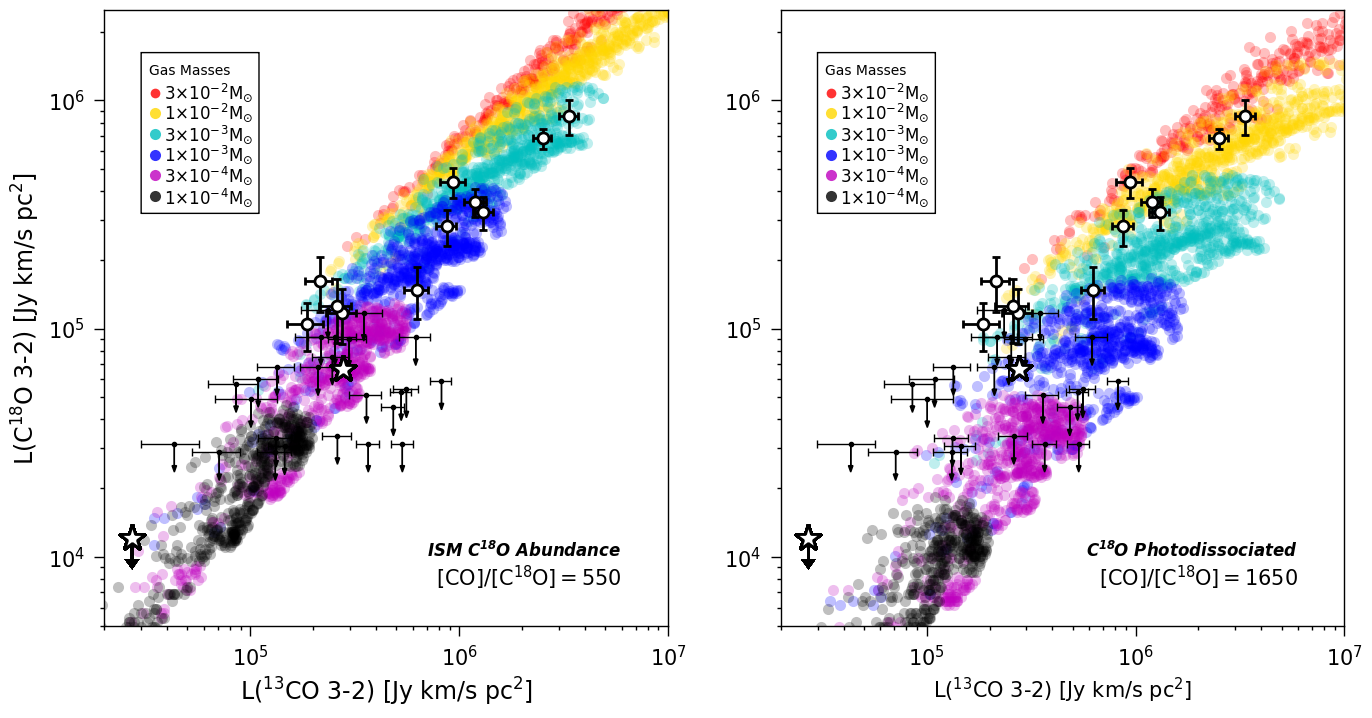

In [20]:
### SAVE FIGURE
fig.savefig('../output/figure_04.png', bbox_inches='tight', dpi=100)
fig

In [21]:
plt.close('all')